In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from matplotlib import style
%matplotlib inline
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [39]:
style.use("ggplot")

In [7]:
hankyung_df = pd.read_csv("한경뉴스.csv", encoding="ANSI")

In [14]:
sk_df = pd.read_csv("SK이노베이션.csv", encoding="ANSI")

In [8]:
hankyung_df.head()

,dates,titles,paragraphs
0,2020-06-05,"삼성 온라인채용 확산…SKT """"화상면접"""" LG """"필기시험 추진""""",‘화상회의 솔루션’에 대해서도 깊은 관심을 드러내고 있다. 지난달 입사시험을 치르...
1,2020-06-04,"SK, 아시아 최대 저가항공 에어아시아에 1000억 투자 검토",SK그룹이 아시아 최대 저비용항공사 에어아시아에 약 1000억원을 투자하는 방안을 ...
2,2020-06-04,마스크 수출 허용에 관련주 '들썩'...수익 제대로 높이려면,새로운 상품에 대해 자세히 알고 싶은 투자자는 고객상담센터 * 증권사 미수/신용 ...
3,2020-06-04,TV에서 보던 진짜 주식전문가를 '무료카톡방'에서 만날 수 있다.,"주목된다. 최근 핫이슈 종목 삼성중공업, 셀트리온제약, 카카오, SK하이닉..."
4,2020-06-04,"""""전기차 배터리 대란 우려에…"""" 글로벌 '합작 열풍' 분다",지리차와의 공장은 부지 선정 단계다. 업계에 따르면 현대차도 글로벌 추세에 발맞춰...


In [21]:
sk_df.dates.tail()

2396    2020-06-01
2397    2020-06-02
2398    2020-06-03
2399    2020-06-04
2400    2020-06-05
Name: dates, dtype: object

In [30]:
sk_df.end_price.head()

0    197500.0
1    190500.0
2    192500.0
3    191500.0
4    186500.0
Name: end_price, dtype: float64

In [35]:
sk_df["end_price_diff"] = sk_df.iloc[:, 2:].diff().end_price

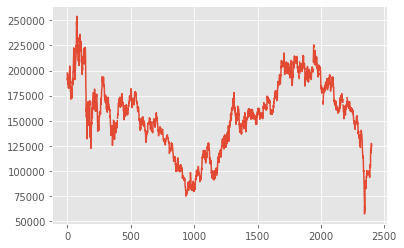

In [40]:
plt.plot(sk_df.end_price)

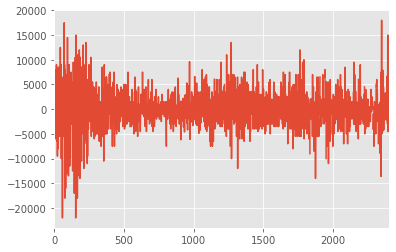

In [41]:
sk_df.end_price_diff.plot()

In [44]:
sk_news = sk_df.loc[sk_df.titles.isna() == 0, ["dates", "titles"]]

In [45]:
sk_news.head()

,dates,titles
79,2011-04-29,"SK이노베이션, 분기사상 최초 수출 11조 돌파하며 매출 수직상승"
98,2011-05-30,"SK이노베이션, 배터리 서산 공장으로 ‘녹색이노베이션’ 나선다"
102,2011-06-03,"SK종합화학, 협력사와 함께하는 동반성장 간담회 열어"
114,2011-06-22,"최태원 SK회장, ‘Green Business’ 직접 챙긴다"
141,2011-07-29,"SK이노베이션, 2분기 매출 17조 1,779억원, 영업이익 4,513억원"


In [47]:
sk_news.shape

(460, 2)

In [54]:
sk_price = sk_df.loc[sk_df.end_price.isna() == 0, ["dates", "end_price", "start_price", "high_price", "low_price", "amount"]]

In [55]:
sk_price.shape

(2348, 6)

In [57]:
sk_price.head()

,dates,end_price,start_price,high_price,low_price,amount
0,2011-01-04,197500.0,194500.0,202000.0,192000.0,707719.0
1,2011-01-05,190500.0,195500.0,197500.0,189500.0,855655.0
2,2011-01-06,192500.0,192000.0,194000.0,188500.0,566165.0
3,2011-01-07,191500.0,190500.0,193000.0,189500.0,371769.0
4,2011-01-10,186500.0,190000.0,197000.0,184500.0,1125833.0


In [60]:
sk_price["dates"] = pd.to_datetime(sk_price.dates)

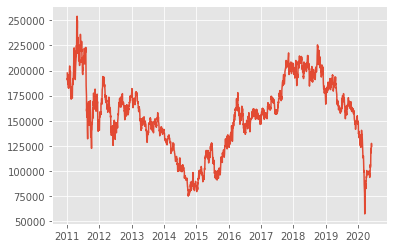

In [61]:
plt.plot(sk_price.dates, sk_price.end_price)

In [64]:
sk_price["end_price_diff"] = sk_price.end_price.diff()

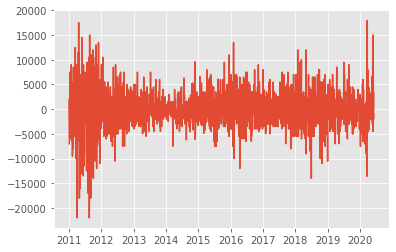

In [68]:
plt.plot(sk_price.dates, sk_price.end_price_diff)

In [69]:
sk_news.head()

,dates,titles
79,2011-04-29,"SK이노베이션, 분기사상 최초 수출 11조 돌파하며 매출 수직상승"
98,2011-05-30,"SK이노베이션, 배터리 서산 공장으로 ‘녹색이노베이션’ 나선다"
102,2011-06-03,"SK종합화학, 협력사와 함께하는 동반성장 간담회 열어"
114,2011-06-22,"최태원 SK회장, ‘Green Business’ 직접 챙긴다"
141,2011-07-29,"SK이노베이션, 2분기 매출 17조 1,779억원, 영업이익 4,513억원"


In [74]:
hankyung_df.dates = pd.to_datetime(hankyung_df.dates)

In [75]:
hankyung_df.head()

,dates,titles,paragraphs
0,2020-06-05,"삼성 온라인채용 확산…SKT """"화상면접"""" LG """"필기시험 추진""""",‘화상회의 솔루션’에 대해서도 깊은 관심을 드러내고 있다. 지난달 입사시험을 치르...
1,2020-06-04,"SK, 아시아 최대 저가항공 에어아시아에 1000억 투자 검토",SK그룹이 아시아 최대 저비용항공사 에어아시아에 약 1000억원을 투자하는 방안을 ...
2,2020-06-04,마스크 수출 허용에 관련주 '들썩'...수익 제대로 높이려면,새로운 상품에 대해 자세히 알고 싶은 투자자는 고객상담센터 * 증권사 미수/신용 ...
3,2020-06-04,TV에서 보던 진짜 주식전문가를 '무료카톡방'에서 만날 수 있다.,"주목된다. 최근 핫이슈 종목 삼성중공업, 셀트리온제약, 카카오, SK하이닉..."
4,2020-06-04,"""""전기차 배터리 대란 우려에…"""" 글로벌 '합작 열풍' 분다",지리차와의 공장은 부지 선정 단계다. 업계에 따르면 현대차도 글로벌 추세에 발맞춰...


In [81]:
sk_price.head()

,dates,end_price,start_price,high_price,low_price,amount,end_price_diff
0,2011-01-04,197500.0,194500.0,202000.0,192000.0,707719.0,NaN
1,2011-01-05,190500.0,195500.0,197500.0,189500.0,855655.0,-7000.0
2,2011-01-06,192500.0,192000.0,194000.0,188500.0,566165.0,2000.0
3,2011-01-07,191500.0,190500.0,193000.0,189500.0,371769.0,-1000.0
4,2011-01-10,186500.0,190000.0,197000.0,184500.0,1125833.0,-5000.0


In [83]:
hankyung_df.shape

(4570, 3)

In [97]:
hankyung_df.iloc[:, 0:2]

dates     datetime64[ns]
titles            object
dtype: object

In [124]:
hankyung_news = hankyung_df.iloc[:, 0:2].groupby("dates")["titles"].apply(lambda x: ', '.join(str(v) for v in x)).to_frame().reset_index()

In [125]:
hankyung_news.shape

(1820, 2)

In [126]:
hankyung_news.head()

,dates,titles
0,2011-11-01,"11월엔 덜 오르고 소외된 대형 '매수'-IBK, 외국인 '외도' 끝?…공매도 커버..."
1,2011-11-02,"우리투자, 3일까지 최대 43% 수익 ELS 7종 판매, KB투자증권, ELW 6종..."
2,2011-11-03,"신한금융투자,내년 코스피 1700-2200 전망"
3,2011-11-04,코스피 사흘 만에 반등…1920선
4,2011-11-07,"""""안도랠리 후반부…선택과 집중 전략""""-현대, 안도랠리 즐기려면?…중소형·실적개선..."


In [127]:
sk_price.shape

(2348, 7)

In [132]:
sk_price.loc[sk_price.dates == "2011-11-01", :]

,dates,end_price,start_price,high_price,low_price,amount,end_price_diff
206,2011-11-01,167000.0,168000.0,171500.0,166000.0,569658.0,-3500.0


In [176]:
sk_price.shape

(2348, 7)

In [177]:
sk_price = sk_price.drop_duplicates(subset="dates")

In [156]:
hankyung_news.set_index("dates").index.is_unique

True

In [179]:
sk_price_filtered1 = sk_price.loc[206:, :].reset_index(drop=True).set_index("dates")

In [183]:
df = pd.concat([hankyung_news.set_index("dates"), sk_price_filtered1], axis=1)

In [184]:
df.shape

(2450, 7)

In [189]:
df.head()

,titles,end_price,start_price,high_price,low_price,amount,end_price_diff
dates,,,,,,,
2011-11-01,"11월엔 덜 오르고 소외된 대형 '매수'-IBK, 외국인 '외도' 끝?…공매도 커버...",167000.0,168000.0,171500.0,166000.0,569658.0,-3500.0
2011-11-02,"우리투자, 3일까지 최대 43% 수익 ELS 7종 판매, KB투자증권, ELW 6종...",166500.0,161000.0,167000.0,158000.0,1046939.0,-500.0
2011-11-03,"신한금융투자,내년 코스피 1700-2200 전망",161500.0,167000.0,167500.0,159500.0,504255.0,-5000.0
2011-11-04,코스피 사흘 만에 반등…1920선,174500.0,167500.0,175500.0,167000.0,920652.0,13000.0
2011-11-07,"""""안도랠리 후반부…선택과 집중 전략""""-현대, 안도랠리 즐기려면?…중소형·실적개선...",172500.0,175500.0,177000.0,171500.0,404488.0,-2000.0


In [190]:
def convert_to_binary(num):
    if num < 0:
        return 0
    else:
        return 1

In [194]:
df["labels"] = df.end_price_diff.apply(convert_to_binary)

In [201]:
data_df = df.loc[:, ["titles", "labels"]]

In [204]:
data_df.reset_index(inplace=True)

In [325]:
tokenizer = Tokenizer(oov_token=1)

In [326]:
def tokenization(texts):
    tokenizer.fit_on_texts(texts)
    token_list = tokenizer.texts_to_sequences(texts)
    total_words = len(tokenizer.word_index) + 1
    return token_list, total_words

In [327]:
data_df.dropna(inplace = True)

In [328]:
corpus, total_words = tokenization(data_df.titles)

In [329]:
maxlen = max(len(x) for x in corpus)

In [330]:
def get_padded_sequences(corpus, maxlen):
    padded_corpus = pad_sequences(corpus, maxlen=maxlen + 1, padding="pre")
    return padded_corpus

In [331]:
padded_corpus = get_padded_sequences(corpus, maxlen)

In [345]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=maxlen + 1))
model.add(Bidirectional(LSTM(50, activation="tanh", return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(50, activation="tanh", return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(50, activation="tanh")))
model.add(BatchNormalization())
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(1, activation="softmax"))

In [346]:
model.compile(optimizer=Adam(learning_rate=0.1), loss="binary_crossentropy", metrics=["accuracy"])

In [343]:
labels = np.array(data_df.labels)

In [398]:
hist = model.fit(padded_corpus, labels, epochs=10,
                class_weight={0:2, 1:1})

Train on 1820 samples
Epoch 1/10
1820/1820 [==============================] - 20s 11ms/sample - loss: 11.6937 - accuracy: 0.6187
Epoch 2/10
1820/1820 [==============================] - 14s 8ms/sample - loss: 11.6937 - accuracy: 0.6187
Epoch 3/10
1820/1820 [==============================] - 14s 8ms/sample - loss: 11.6937 - accuracy: 0.6187
Epoch 4/10
1820/1820 [==============================] - 14s 8ms/sample - loss: 11.6937 - accuracy: 0.6187
Epoch 5/10
1820/1820 [==============================] - 14s 8ms/sample - loss: 11.6937 - accuracy: 0.6187
Epoch 6/10
1820/1820 [==============================] - 14s 8ms/sample - loss: 11.6937 - accuracy: 0.6187
Epoch 7/10
1820/1820 [==============================] - 14s 8ms/sample - loss: 11.6937 - accuracy: 0.6187
Epoch 8/10
1820/1820 [==============================] - 14s 8ms/sample - loss: 11.6937 - accuracy: 0.6187
Epoch 9/10
1820/1820 [==============================] - 14s 8ms/sample - loss: 11.6937 - accuracy: 0.6187
Epoch 10/10
1820/1820 [

In [405]:
sequence = tokenizer.texts_to_sequences("한기평, SK이노베이션 신용등급전망 '안정적→부정적' 하향")

In [409]:
flattened_sequence = []

In [410]:
for x in sequence:
    for y in x:
        flattened_sequence.append(y)

In [411]:
flattened_sequence = [flattened_sequence]

In [412]:
padded_sequence = pad_sequences(flattened_sequence, maxlen=128, padding="pre")

In [413]:
model.predict(padded_sequence)

array([[1.]], dtype=float32)